First, I'll import the data file and filter for 'Standard' trade type

In [1]:
import pandas as pd
filepath = "./data/MarketFinance_Public_Loan_Book.xlsx"
data = pd.read_excel(filepath)
data = data[data['Trade Type'] == 'Standard'].reset_index(drop=True)
data.head()

,Trade ID,Seller ID,Trade Type,Advance Date,Expected Payment Date,Settlement Date,In Arrears,In Arrears on Date,Crystallised Loss Date,Payment State,...,Advance,Advance %,Discount %,Discount On (Advance or Face Value),Outstanding Principal,Face Value (GBP),Advance (GBP),Outstanding Principal (GBP),Annualised Gross Yield %,Crystallised Loss
0,60896,44830,Standard,2018-10-11,2019-01-07 00:00:00 +0000,NaT,No,NaT,NaT,Awaiting Repayment,...,2617.50,75.0,1.0,Advance,2617.50,2637.9273,1978.4455,1978.4455,12.682503,NaN
1,61343,15942,Standard,2018-10-11,2018-11-26 00:00:00 +0000,NaT,No,NaT,NaT,Awaiting Repayment,...,5100.00,85.0,0.7,Advance,5100.00,6000.0000,5100.0000,5100.0000,8.731066,NaN
2,61346,25937,Standard,2018-10-11,2018-12-14 00:00:00 +0000,NaT,No,NaT,NaT,Awaiting Repayment,...,2819.84,65.0,1.2,Advance,2819.84,4338.2200,2819.8400,2819.8400,15.389462,NaN
3,61361,2098,Standard,2018-10-11,2018-12-21 00:00:00 +0000,NaT,No,NaT,NaT,Awaiting Repayment,...,2323.20,80.0,1.2,Advance,2323.20,2904.0000,2323.2000,2323.2000,15.389462,NaN
4,61362,14523,Standard,2018-10-11,2018-12-19 00:00:00 +0000,NaT,No,NaT,NaT,Awaiting Repayment,...,40142.80,90.0,0.8,Advance,40142.80,44603.1100,40142.8000,40142.8000,10.033869,NaN


Let's look at some information about the data: data types, null count in particular.

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27766 entries, 0 to 27765
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Trade ID                             27766 non-null  int64         
 1   Seller ID                            27766 non-null  int64         
 2   Trade Type                           27766 non-null  object        
 3   Advance Date                         27766 non-null  datetime64[ns]
 4   Expected Payment Date                27766 non-null  object        
 5   Settlement Date                      26791 non-null  datetime64[ns]
 6   In Arrears                           27766 non-null  object        
 7   In Arrears on Date                   525 non-null    datetime64[ns]
 8   Crystallised Loss Date               457 non-null    datetime64[ns]
 9   Payment State                        27766 non-null  object        
 10  Price Grad

I want to add new features: Expected Duration in Days, and Previously Settled Trades. 

Firstly I'll go for Expected Duration in Days. The fields 'Expected Payment Date' and 'Advance Date' are of different types, so I'll have to resolve that, and then extract the days.

In [3]:
data['Expected Payment Date'] = pd.to_datetime(data['Expected Payment Date']).dt.tz_localize(None)
data['ExpectedDurationDays'] = (data['Expected Payment Date'] - data['Advance Date']).astype('timedelta64[D]')
data.head()

,Trade ID,Seller ID,Trade Type,Advance Date,Expected Payment Date,Settlement Date,In Arrears,In Arrears on Date,Crystallised Loss Date,Payment State,...,Advance %,Discount %,Discount On (Advance or Face Value),Outstanding Principal,Face Value (GBP),Advance (GBP),Outstanding Principal (GBP),Annualised Gross Yield %,Crystallised Loss,ExpectedDurationDays
0,60896,44830,Standard,2018-10-11,2019-01-07,NaT,No,NaT,NaT,Awaiting Repayment,...,75.0,1.0,Advance,2617.50,2637.9273,1978.4455,1978.4455,12.682503,NaN,88.0
1,61343,15942,Standard,2018-10-11,2018-11-26,NaT,No,NaT,NaT,Awaiting Repayment,...,85.0,0.7,Advance,5100.00,6000.0000,5100.0000,5100.0000,8.731066,NaN,46.0
2,61346,25937,Standard,2018-10-11,2018-12-14,NaT,No,NaT,NaT,Awaiting Repayment,...,65.0,1.2,Advance,2819.84,4338.2200,2819.8400,2819.8400,15.389462,NaN,64.0
3,61361,2098,Standard,2018-10-11,2018-12-21,NaT,No,NaT,NaT,Awaiting Repayment,...,80.0,1.2,Advance,2323.20,2904.0000,2323.2000,2323.2000,15.389462,NaN,71.0
4,61362,14523,Standard,2018-10-11,2018-12-19,NaT,No,NaT,NaT,Awaiting Repayment,...,90.0,0.8,Advance,40142.80,44603.1100,40142.8000,40142.8000,10.033869,NaN,69.0


Looks good. Now for Previously Settled Trades. I'll want to count by SellerID previous trades to the row in questions. I'll add in a settled column as an idicator and then sum over that.

###### Note: The brief said to only count those where the Settlement Date is BEFORE the Advance Date. However, no such instances existed in the dataset provided. For the sake of argument, I've gone with Settlement Date AFTER Advance Date.

In [4]:
def settled_trade(a_date, s_date, state):
    if state != "Paid":
        settled_trade = 0
    else:
        if s_date > a_date:
            settled_trade = 1
        else:
            settled_trade = 0
    return settled_trade

data['Settled Trade'] = data.apply(lambda x: settled_trade(x['Advance Date'], 
                                        x['Settlement Date'],
                                        x['Payment State']), axis=1)
data.head()

,Trade ID,Seller ID,Trade Type,Advance Date,Expected Payment Date,Settlement Date,In Arrears,In Arrears on Date,Crystallised Loss Date,Payment State,...,Discount %,Discount On (Advance or Face Value),Outstanding Principal,Face Value (GBP),Advance (GBP),Outstanding Principal (GBP),Annualised Gross Yield %,Crystallised Loss,ExpectedDurationDays,Settled Trade
0,60896,44830,Standard,2018-10-11,2019-01-07,NaT,No,NaT,NaT,Awaiting Repayment,...,1.0,Advance,2617.50,2637.9273,1978.4455,1978.4455,12.682503,NaN,88.0,0
1,61343,15942,Standard,2018-10-11,2018-11-26,NaT,No,NaT,NaT,Awaiting Repayment,...,0.7,Advance,5100.00,6000.0000,5100.0000,5100.0000,8.731066,NaN,46.0,0
2,61346,25937,Standard,2018-10-11,2018-12-14,NaT,No,NaT,NaT,Awaiting Repayment,...,1.2,Advance,2819.84,4338.2200,2819.8400,2819.8400,15.389462,NaN,64.0,0
3,61361,2098,Standard,2018-10-11,2018-12-21,NaT,No,NaT,NaT,Awaiting Repayment,...,1.2,Advance,2323.20,2904.0000,2323.2000,2323.2000,15.389462,NaN,71.0,0
4,61362,14523,Standard,2018-10-11,2018-12-19,NaT,No,NaT,NaT,Awaiting Repayment,...,0.8,Advance,40142.80,44603.1100,40142.8000,40142.8000,10.033869,NaN,69.0,0


In [5]:
#data['PeviouslySettledTrades'] = 0
for i in range(len(data)):
    seller = data.loc[i, 'Seller ID']
    date = data.loc[i, 'Advance Date']
    if i < len(data)-1:
        data.loc[i, 'PreviouslySettledTrades'] = data.loc[(data['Seller ID']==seller) & (data['Advance Date'] <= date), 'Settled Trade'].sum()
    else:
        data.loc[i, 'PreviouslySettledTrades'] = 0
        
data.head()

,Trade ID,Seller ID,Trade Type,Advance Date,Expected Payment Date,Settlement Date,In Arrears,In Arrears on Date,Crystallised Loss Date,Payment State,...,Discount On (Advance or Face Value),Outstanding Principal,Face Value (GBP),Advance (GBP),Outstanding Principal (GBP),Annualised Gross Yield %,Crystallised Loss,ExpectedDurationDays,Settled Trade,PreviouslySettledTrades
0,60896,44830,Standard,2018-10-11,2019-01-07,NaT,No,NaT,NaT,Awaiting Repayment,...,Advance,2617.50,2637.9273,1978.4455,1978.4455,12.682503,NaN,88.0,0,5.0
1,61343,15942,Standard,2018-10-11,2018-11-26,NaT,No,NaT,NaT,Awaiting Repayment,...,Advance,5100.00,6000.0000,5100.0000,5100.0000,8.731066,NaN,46.0,0,55.0
2,61346,25937,Standard,2018-10-11,2018-12-14,NaT,No,NaT,NaT,Awaiting Repayment,...,Advance,2819.84,4338.2200,2819.8400,2819.8400,15.389462,NaN,64.0,0,4.0
3,61361,2098,Standard,2018-10-11,2018-12-21,NaT,No,NaT,NaT,Awaiting Repayment,...,Advance,2323.20,2904.0000,2323.2000,2323.2000,15.389462,NaN,71.0,0,34.0
4,61362,14523,Standard,2018-10-11,2018-12-19,NaT,No,NaT,NaT,Awaiting Repayment,...,Advance,40142.80,44603.1100,40142.8000,40142.8000,10.033869,NaN,69.0,0,108.0


We're good to go. Before we apply a logistic regression model using these two features, I'll encode the 'In Arrears' to be 0 or 1. 

In [8]:
data = data.replace({'In Arrears': {'No': 0, 'Yes': 1}})                                                       
data.head()

,Trade ID,Seller ID,Trade Type,Advance Date,Expected Payment Date,Settlement Date,In Arrears,In Arrears on Date,Crystallised Loss Date,Payment State,...,Discount On (Advance or Face Value),Outstanding Principal,Face Value (GBP),Advance (GBP),Outstanding Principal (GBP),Annualised Gross Yield %,Crystallised Loss,ExpectedDurationDays,Settled Trade,PreviouslySettledTrades
0,60896,44830,Standard,2018-10-11,2019-01-07,NaT,0,NaT,NaT,Awaiting Repayment,...,Advance,2617.50,2637.9273,1978.4455,1978.4455,12.682503,NaN,88.0,0,5.0
1,61343,15942,Standard,2018-10-11,2018-11-26,NaT,0,NaT,NaT,Awaiting Repayment,...,Advance,5100.00,6000.0000,5100.0000,5100.0000,8.731066,NaN,46.0,0,55.0
2,61346,25937,Standard,2018-10-11,2018-12-14,NaT,0,NaT,NaT,Awaiting Repayment,...,Advance,2819.84,4338.2200,2819.8400,2819.8400,15.389462,NaN,64.0,0,4.0
3,61361,2098,Standard,2018-10-11,2018-12-21,NaT,0,NaT,NaT,Awaiting Repayment,...,Advance,2323.20,2904.0000,2323.2000,2323.2000,15.389462,NaN,71.0,0,34.0
4,61362,14523,Standard,2018-10-11,2018-12-19,NaT,0,NaT,NaT,Awaiting Repayment,...,Advance,40142.80,44603.1100,40142.8000,40142.8000,10.033869,NaN,69.0,0,108.0


As a final thing, let's check the proportion of instances when the trade is in arrears.

In [11]:
(data['In Arrears'].sum()/len(data)) * 100

1.8908016999207664

As expected, there's a heavy class imbalance in the data. I'm going to apply over sampling using SMOTE.

In [18]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

features = ['ExpectedDurationDays', 'PreviouslySettledTrades']
label = 'In Arrears'
X, y = data[features], data[label]

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X, os_data_y = os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=features)
os_data_y = pd.DataFrame(data=os_data_y, columns=[label])
# Check numbers of data
print("Lenght of oversampled data: ", len(os_data_X))
print("Number of good scores: ", len(os_data_y[os_data_y[label]==0]))
print("Number of bad scores: ", len(os_data_y[os_data_y[label]==1]))
print("Proportion of good scores: ", len(os_data_y[os_data_y[label]==0])/len(os_data_X))
print("Proportion of bad scores: ", len(os_data_y[os_data_y[label]==1])/len(os_data_X))

Lenght of oversampled data:  38152
Number of good scores:  19076
Number of bad scores:  19076
Proportion of good scores:  0.5
Proportion of bad scores:  0.5


Now let's build a logistic regression model.

In [19]:
# Create preprocessing and training pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([('preprocessing', StandardScaler()),
                     ('logregressor', LogisticRegression(solver="lbfgs"))])

# Fit the pipeline to train a logistic regression model on the training set
model = pipeline.fit(X_train, (y_train))
print(model)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('logregressor', LogisticRegression())])


Now let's run the model on the test set, and evaluate against the actual classifications.

Confusion Matrix:
 [[8164    1]
 [ 164    1]] 

Accuracy: 0.9801920768307323
Overall Precision: 0.5
Overall Recall: 0.006060606060606061
F1-Score: 0.011976047904191616
AUC: 0.6466135946111451


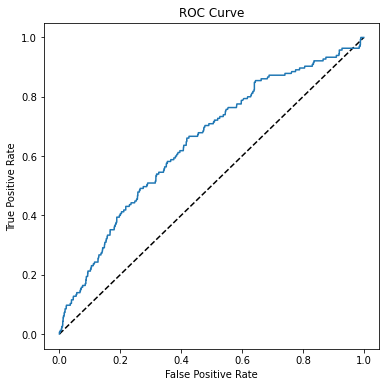

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

# Get predictions from test data
preds = model.predict(X_test)
y_scores = model.predict_proba(X_test)

# Get evaluation metrics
cm = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cm, '\n')
print('Accuracy:', accuracy_score(y_test, preds))
print('Overall Precision:', precision_score(y_test, preds))
print('Overall Recall:', recall_score(y_test, preds))
print('F1-Score:', f1_score(y_test, preds))
auc = roc_auc_score(y_test, y_scores[:,1])
print('AUC: ' + str(auc))

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# Plot ROC Curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0,1], 'k--')
# Plot FPT and TPR achieved by model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

From the above metrics, we can see that there are far too many false negatives, whilst the true positives are far too low. From the ROC curve, we can see that the model predicts the correct classification about 64% of the time.

Let's plot a box and whisker chart to see the relationship between 'In Arrears' and 'Previously Settled Trades'.

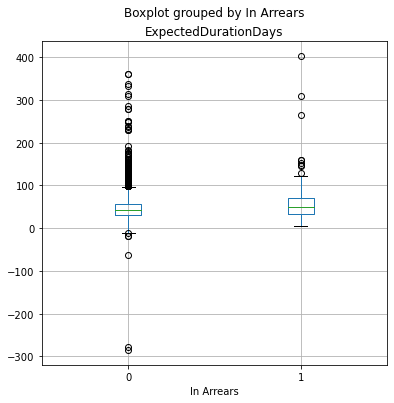

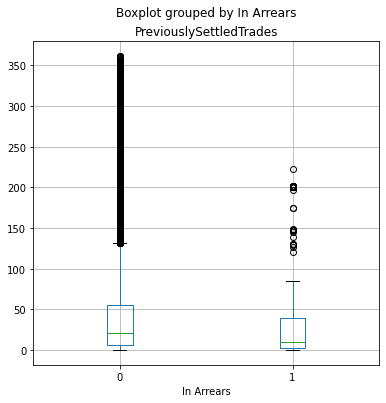

In [22]:
for feature in features:
    data.boxplot(column=feature, by='In Arrears', figsize=(6, 6))
    plt.title(feature)
plt.show()

There are outliers in the upper ends of both variables, heavily focused on those where InArrears = 0. There are also some outliers on the lower end of ExpectedDurationDays.

I'm going to trim the data so that PreviouslySettledTrades are with 75th percentile, and ExpectedDurationDays are between 1st and 90th percentiles. I'll put this is a new dataframe called 'data_trim'.

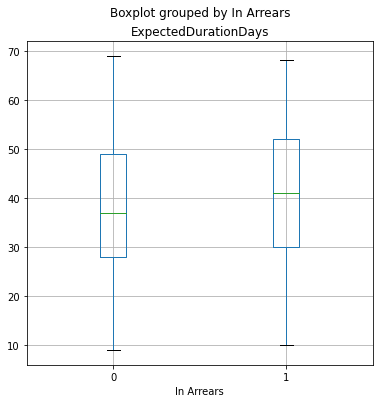

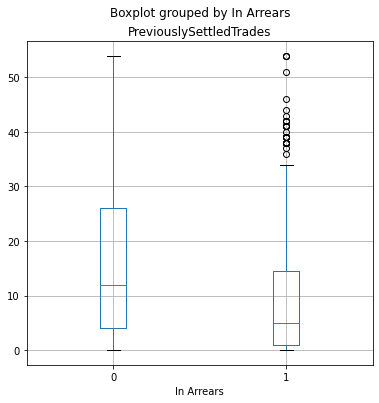

In [24]:
pst_75 = data.PreviouslySettledTrades.quantile(0.75)
data_trim = data[data.PreviouslySettledTrades < pst_75]

ed_01 = data_trim.ExpectedDurationDays.quantile(0.01)
ed_90 = data_trim.ExpectedDurationDays.quantile(0.90)
data_trim = data_trim[data_trim.ExpectedDurationDays < ed_90]
data_trim = data_trim[data_trim.ExpectedDurationDays > ed_01]

for feature in features:
    data_trim.boxplot(column=feature, by='In Arrears', figsize=(6, 6))
    plt.title(feature)
plt.show()

That looks a bit better. Let's try training and running a model on this trimmed dataframe.

C:\Users\adamp\Documents\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Confusion Matrix:
 [[2959 2422]
 [  34   69]] 

Accuracy: 0.5521517140773158
Overall Precision: 0.027699718988358088
Overall Recall: 0.6699029126213593
F1-Score: 0.05319969159599074
AUC: 0.6448994394155632


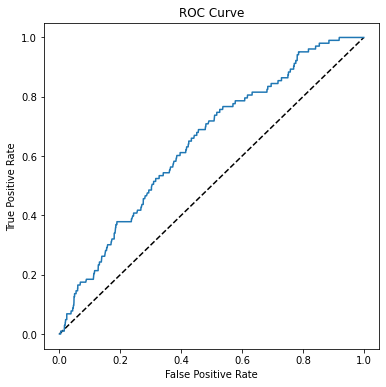

In [26]:
# Set X and y
X, y = data_trim[features], data_trim[label]

# Use SMOTE to oversample and split the data into training and test sets
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X, os_data_y = os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y = pd.DataFrame(data=os_data_y, columns=[label])

X_train, y_train = os_data_X.values, os_data_y.values

# Create preprocessing and training pipeline, and fit to data

pipeline = Pipeline([('preprocessing', StandardScaler()),
                     ('logregressor', LogisticRegression(solver="lbfgs"))])
model = pipeline.fit(X_train, (y_train))

# Get predictions from test data
preds = model.predict(X_test)
y_scores = model.predict_proba(X_test)

# Get evaluation metrics
cm = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cm, '\n')
print('Accuracy:', accuracy_score(y_test, preds))
print('Overall Precision:', precision_score(y_test, preds))
print('Overall Recall:', recall_score(y_test, preds))
print('F1-Score:', f1_score(y_test, preds))
auc = roc_auc_score(y_test, y_scores[:,1])
print('AUC: ' + str(auc))

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# Plot ROC Curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0,1], 'k--')
# Plot FPT and TPR achieved by model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

F1 Score has slightly improved, but it's still not a great performing model. It could be that there are not enough features, ie not enough distinctive information that differentiates between whether a trade is in arrears or not. Let's take another look at the numeric features available.

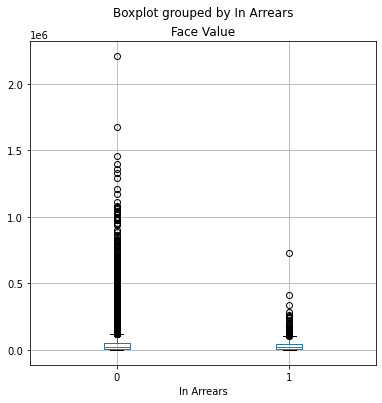

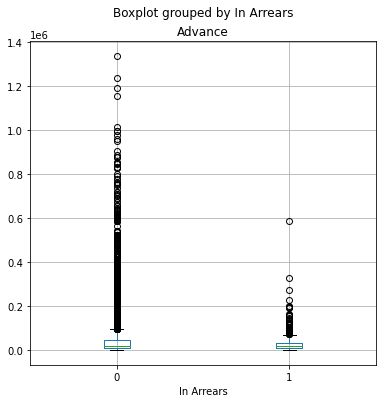

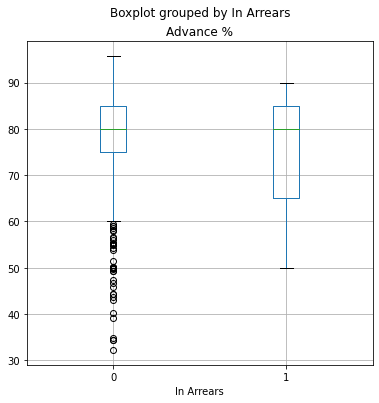

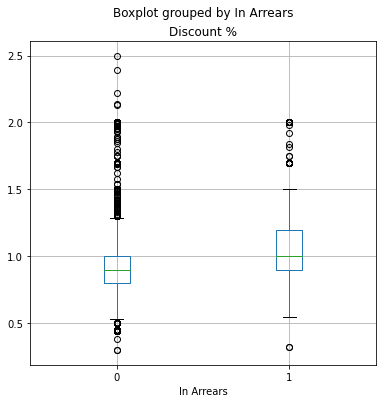

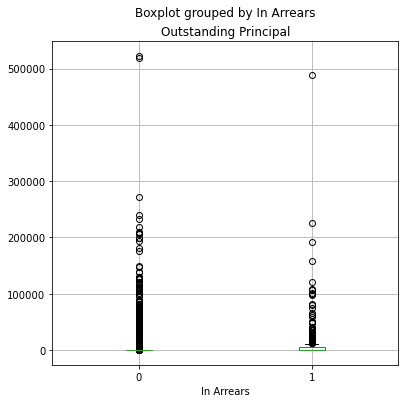

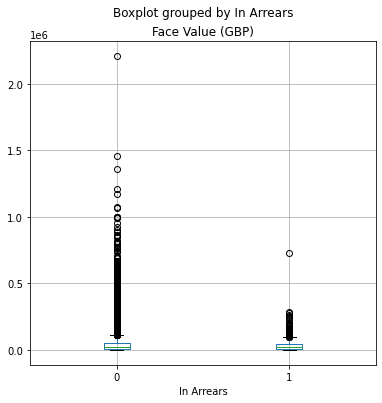

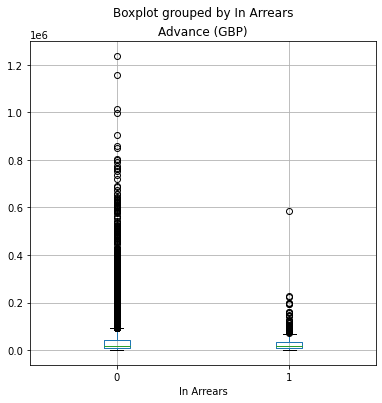

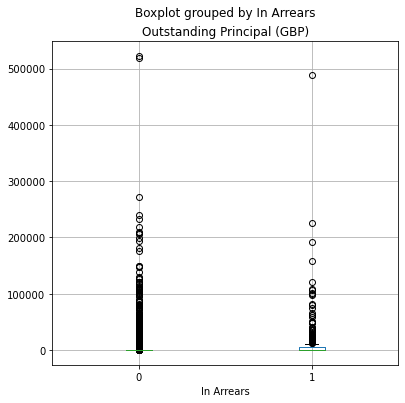

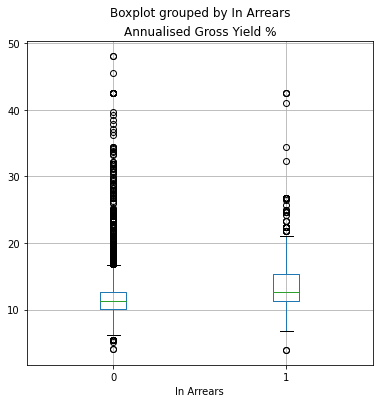

In [27]:
numeric_features = ['Face Value', 'Advance', 'Advance %', 'Discount %', 'Outstanding Principal', 'Face Value (GBP)',
                    'Advance (GBP)', 'Outstanding Principal (GBP)', 'Annualised Gross Yield %']

for feature in numeric_features:
    data.boxplot(column=feature, by='In Arrears', figsize = (6, 6))
    plt.title(feature)
plt.show()

From a birdseye view, looks like 'Advance %', 'Discount %' and 'Annualised Gross Yield %' could also have some predictive power. I suspect that the categorical variabls 'Payment State' and 'Price Grade' would also have use. In order to incorporate these variables into the model, I need to encode them using one hot encoding.

In [28]:
payment_state_oh = pd.get_dummies(data['Payment State'], prefix='PaymentState')
price_grade_oh = pd.get_dummies(data['Price Grade'], prefix='PriceGrade')

data = pd.concat([data, payment_state_oh, price_grade_oh], axis=1)
data.head()

,Trade ID,Seller ID,Trade Type,Advance Date,Expected Payment Date,Settlement Date,In Arrears,In Arrears on Date,Crystallised Loss Date,Payment State,...,PriceGrade_2,PriceGrade_3,PriceGrade_4,PriceGrade_5,PriceGrade_6,PriceGrade_7,PriceGrade_8,PriceGrade_9,PriceGrade_10,PriceGrade_Unclassified
0,60896,44830,Standard,2018-10-11,2019-01-07,NaT,0,NaT,NaT,Awaiting Repayment,...,0,0,0,0,1,0,0,0,0,0
1,61343,15942,Standard,2018-10-11,2018-11-26,NaT,0,NaT,NaT,Awaiting Repayment,...,0,1,0,0,0,0,0,0,0,0
2,61346,25937,Standard,2018-10-11,2018-12-14,NaT,0,NaT,NaT,Awaiting Repayment,...,0,0,0,0,0,1,0,0,0,0
3,61361,2098,Standard,2018-10-11,2018-12-21,NaT,0,NaT,NaT,Awaiting Repayment,...,0,0,0,0,0,1,0,0,0,0
4,61362,14523,Standard,2018-10-11,2018-12-19,NaT,0,NaT,NaT,Awaiting Repayment,...,0,0,1,0,0,0,0,0,0,0


Full list of features.

In [31]:
features = ['Advance %', 
'Discount %', 
'Annualised Gross Yield %',
'ExpectedDurationDays',
'PreviouslySettledTrades',
'PaymentState_Awaiting Repayment',
'PaymentState_Overdue',
'PaymentState_Paid',
'PaymentState_Partially Paid',
'PaymentState_Repurchase Demanded',
'PaymentState_Repurchased',
'PriceGrade_1',
'PriceGrade_2',
'PriceGrade_3',
'PriceGrade_4',
'PriceGrade_5',
'PriceGrade_6',
'PriceGrade_7',
'PriceGrade_8',
'PriceGrade_9',
'PriceGrade_10',
'PriceGrade_Unclassified'
]

Now let's try training and running a logistic regression model with out extended feature list. I'll do this on the entire dataset.

C:\Users\adamp\Documents\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Confusion Matrix:
 [[7855  310]
 [  66   99]] 

Accuracy: 0.9548619447779112
Overall Precision: 0.24205378973105135
Overall Recall: 0.6
F1-Score: 0.3449477351916376
AUC: 0.9167856148750209


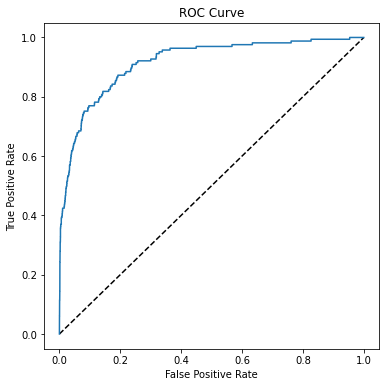

In [33]:
# Set X and y
X, y = data[features], data[label]

# Use SMOTE to oversample and split the data into training and test sets
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X, os_data_y = os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y = pd.DataFrame(data=os_data_y, columns=['In Arrears'])

X_train, y_train = os_data_X.values, os_data_y.values

# Create preprocessing and training pipeline, and fit to data

pipeline = Pipeline([('preprocessing', StandardScaler()),
                     ('logregressor', LogisticRegression(solver="lbfgs"))])
model = pipeline.fit(X_train, (y_train))

# Get predictions from test data
preds = model.predict(X_test)
y_scores = model.predict_proba(X_test)

# Get evaluation metrics
cm = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cm, '\n')
print('Accuracy:', accuracy_score(y_test, preds))
print('Overall Precision:', precision_score(y_test, preds))
print('Overall Recall:', recall_score(y_test, preds))
print('F1-Score:', f1_score(y_test, preds))
auc = roc_auc_score(y_test, y_scores[:,1])
print('AUC: ' + str(auc))

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# Plot ROC Curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0,1], 'k--')
# Plot FPT and TPR achieved by model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

This is looking to be heading in the right direction. The F1-score is significantly higher, as well as precision and AUC. We've been working exclusively with logistic regression. Let's try a different classifier: random forest classifier. 

C:\Users\adamp\Documents\Anaconda\lib\site-packages\sklearn\pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Confusion Matrix:
 [[8122   43]
 [  93   72]] 

Accuracy: 0.9836734693877551
Overall Precision: 0.6260869565217392
Overall Recall: 0.43636363636363634
F1-Score: 0.5142857142857142
AUC: 0.876412997086604


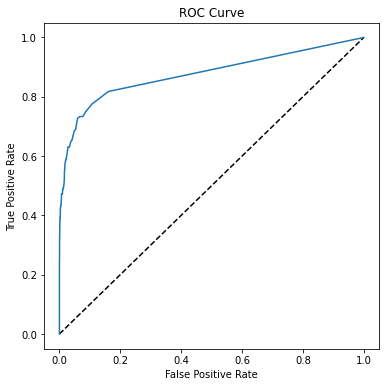

In [36]:
# Set X and y
X, y = data[features], data[label]

# Use SMOTE to oversample and split the data into training and test sets
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X, os_data_y = os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y = pd.DataFrame(data=os_data_y, columns=['In Arrears'])

X_train, y_train = os_data_X.values, os_data_y.values

# Create preprocessing and training pipeline, and fit to data
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([('preprocessing', StandardScaler()),
                     ('logregressor', RandomForestClassifier(n_estimators=100))])
model = pipeline.fit(X_train, (y_train))

# Get predictions from test data
preds = model.predict(X_test)
y_scores = model.predict_proba(X_test)

# Get evaluation metrics
cm = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cm, '\n')
print('Accuracy:', accuracy_score(y_test, preds))
print('Overall Precision:', precision_score(y_test, preds))
print('Overall Recall:', recall_score(y_test, preds))
print('F1-Score:', f1_score(y_test, preds))
auc = roc_auc_score(y_test, y_scores[:,1])
print('AUC: ' + str(auc))

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# Plot ROC Curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0,1], 'k--')
# Plot FPT and TPR achieved by model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

The F1-score and precision has improved more than the cost to recall and AUC. Can still do with some work, but it's getting there.